## Pense como um Cientista de Dados
### Modelos de Árvore e Otimização Bayesiana para Classificação Binária: Casos Práticos no Mundo dos Negócios

### <font color = 'blue'>Capítulo 4. Explorando e Modelando o Risco de Crédito com o *German Credit Dataset*</font>

In [60]:
%load_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,xgboost -u -n -t -z

Last updated: Sat Sep 21 2024 19:28:52-03

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy       : 1.26.4
pandas      : 2.2.2
scikit-learn: 1.4.2
xgboost     : 2.1.1



## Importando as bibliotecas e pacotes necessários

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

In [2]:
# Para reprodutibilidade
SEED = 42

## Carregando os dados do German Credit

In [3]:
# Carregar o dataset German Credit de OpenML
data = fetch_openml(name='credit-g', version=1, as_frame=True)

# Transformar as features e o target em DataFrame do Pandas
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Verificar as primeiras linhas dos dados
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [4]:
# Definindo colunas categóricas e numéricas
# Separar colunas categóricas e numéricas
categorical_columns = X.select_dtypes(include=['category', 'object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

In [5]:
print(f"Numerical Columns:\n{numerical_columns}\n\nCategorical Columns:\n{categorical_columns}")

Numerical Columns:
Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object')

Categorical Columns:
Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker'],
      dtype='object')


## Imputação de valores

In [6]:
# Imputar valores ausentes se houver (usando a moda para categóricas e mediana para numéricas)
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

# Aplicar a imputação
X[categorical_columns] = cat_imputer.fit_transform(X[categorical_columns])
X[numerical_columns] = num_imputer.fit_transform(X[numerical_columns])

## Aplicando o *One-Hot Encoding*

In [7]:
# Usar One-Hot Encoding com a versão atualizada do Scikit-learn
# Criando o encoder com drop='first' para evitar multicolinearidade
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(X[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

# Obter os nomes das colunas geradas pelo One-Hot Encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

# Transformar o array em um DataFrame com os nomes das colunas
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

# Garantir que as colunas codificadas são do tipo float
encoded_cats = pd.DataFrame(encoded_cats, columns=encoded_feature_names).astype(float)

## Padronizando as colunas numéricas com o *StandarScaler*

In [8]:
# Padronizar as colunas numéricas
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

## Concatenando as colunas codificadas

In [9]:
# Concatenar as variáveis numéricas e categóricas codificadas
X_final = pd.concat([X[numerical_columns], encoded_cats], axis=1)

In [11]:
# Verificando o resultado
# Repare nos caracteres estranhos gerados pelo One-Hot
X_final.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'purpose_domestic appliance',
       'purpose_education', 'purpose_furniture/equipment', 'purpose_new car',
       'purpose_other', 'purpose_radio/tv', 'purpose_repairs',
       'purpose_retraining', 'purpose_used car', 'savings_status_500<=X<1000',
       'savings_status_<100', 'savings_status_>=1000',
       'savings_status_no known savings', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_unemployed',
       'personal_status_male div/sep', 'personal_status_male mar/wid',
       'personal_status_male single', 'other_parties_guarantor',
       'other_parties_none'

In [12]:
# Limpar os nomes das colunas para remover caracteres problemáticos
X_final.columns = X_final.columns.str.replace(r'[><=]', '', regex=True)
X_final.columns = X_final.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)

In [13]:
# Converter a variável alvo 'y' para binário (1 para 'bad', 0 para 'good')
y = y.apply(lambda x: 1 if x == 'bad' else 0)

## Verificação final para ver se está tudo em ordem para o modelo

In [15]:
# Garantindo que os nomes das colunas são strings
X_final.columns = X_final.columns.astype(str)

In [16]:
# Verificar o resultado
X_final.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0,checking_status_200,checking_status_nochecking,...,property_magnitude_realestate,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_skilled,job_unempunskillednonres,job_unskilledresident,own_telephone_yes,foreign_worker_yes
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [17]:
# Verificar se é tudo número
X_final.dtypes

duration                                      float64
credit_amount                                 float64
installment_commitment                        float64
residence_since                               float64
age                                           float64
existing_credits                              float64
num_dependents                                float64
checking_status_0                             float64
checking_status_200                           float64
checking_status_nochecking                    float64
credit_history_criticalotherexistingcredit    float64
credit_history_delayedpreviously              float64
credit_history_existingpaid                   float64
credit_history_nocreditsallpaid               float64
purpose_domesticappliance                     float64
purpose_education                             float64
purpose_furnitureequipment                    float64
purpose_newcar                                float64
purpose_other               

In [18]:
# Confirmar que não há dados nulos ou ausentes
X_final.isna().sum()

duration                                      0
credit_amount                                 0
installment_commitment                        0
residence_since                               0
age                                           0
existing_credits                              0
num_dependents                                0
checking_status_0                             0
checking_status_200                           0
checking_status_nochecking                    0
credit_history_criticalotherexistingcredit    0
credit_history_delayedpreviously              0
credit_history_existingpaid                   0
credit_history_nocreditsallpaid               0
purpose_domesticappliance                     0
purpose_education                             0
purpose_furnitureequipment                    0
purpose_newcar                                0
purpose_other                                 0
purpose_radiotv                               0
purpose_repairs                         

## Análise visual

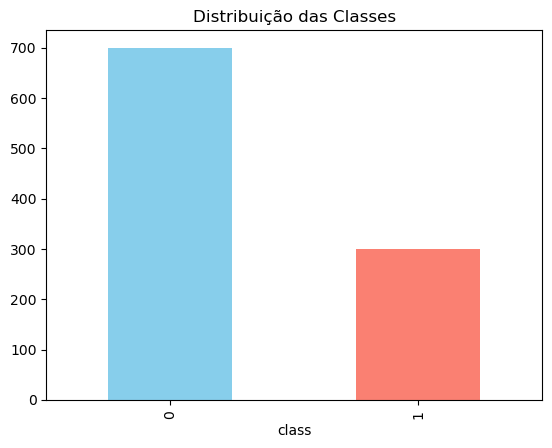

In [19]:
import matplotlib.pyplot as plt
y.value_counts().plot(kind='bar', title='Distribuição das Classes', color=['skyblue', 'salmon']);

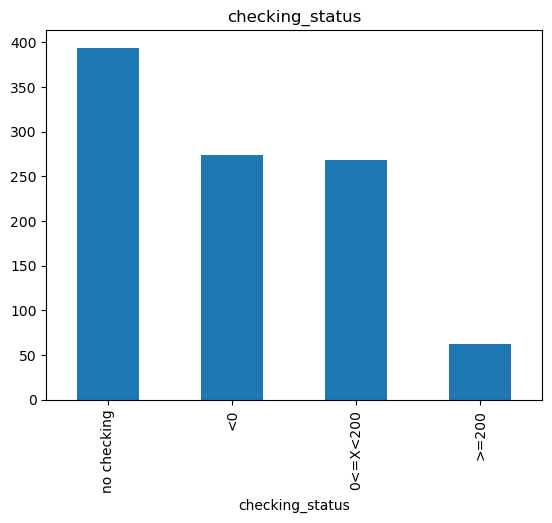

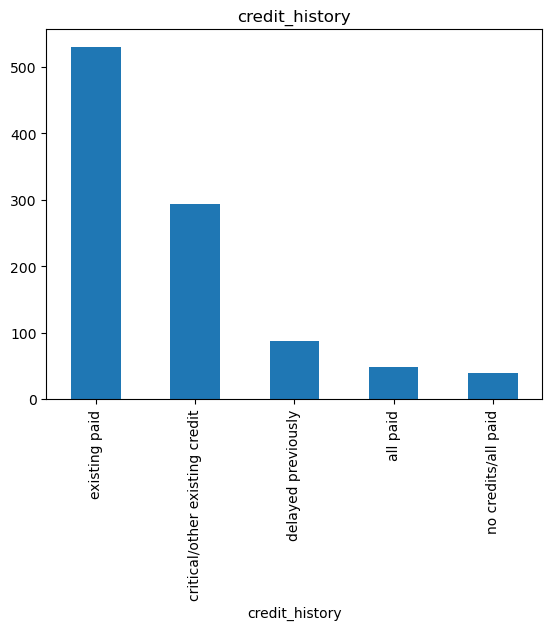

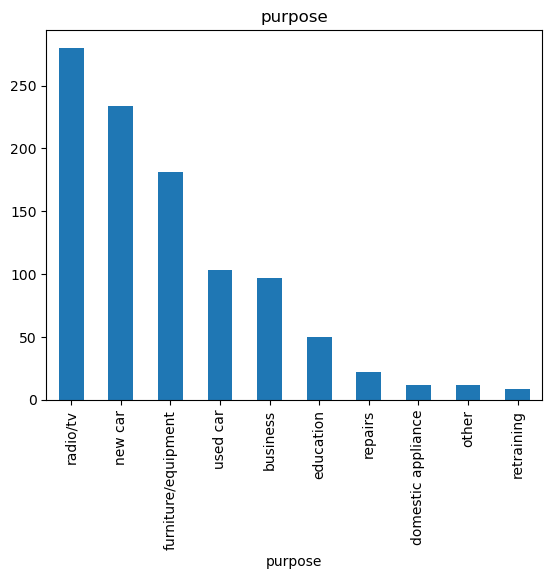

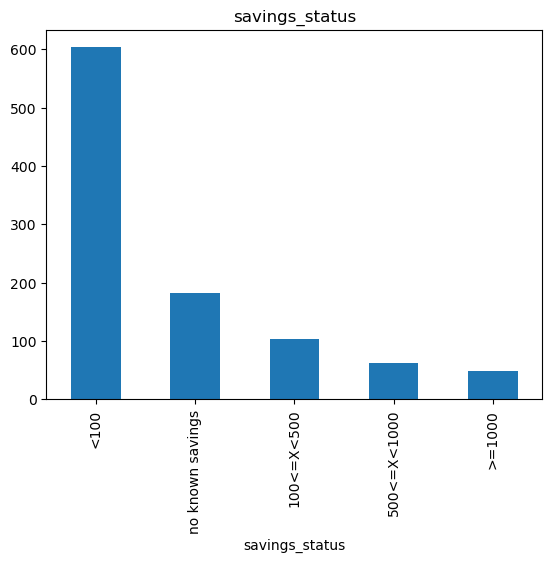

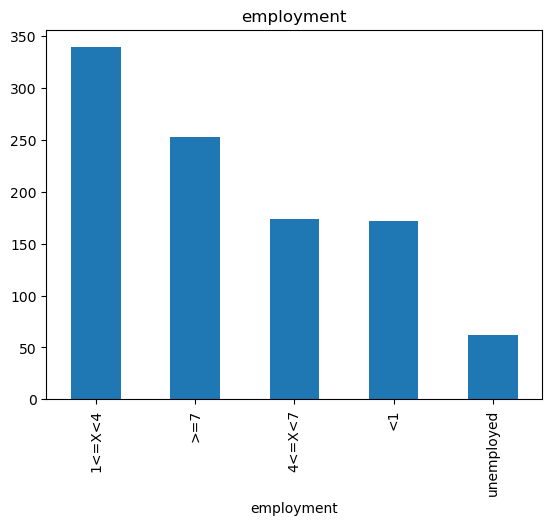

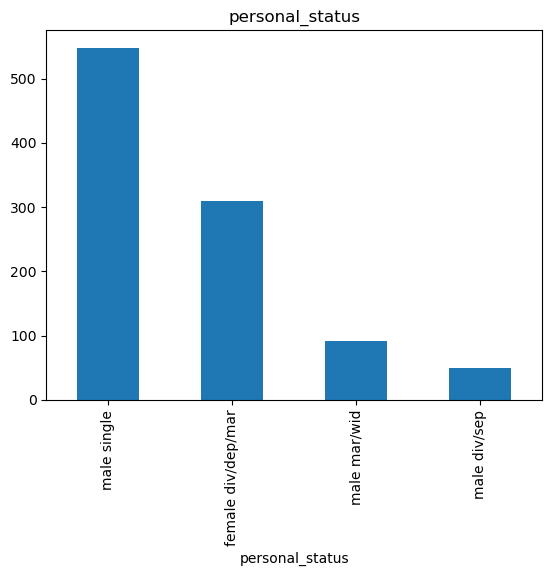

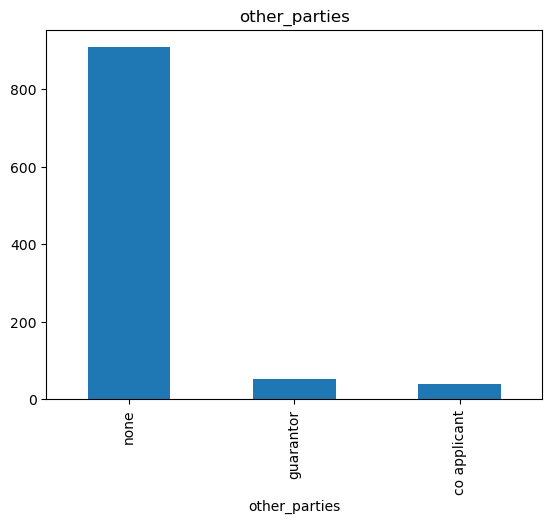

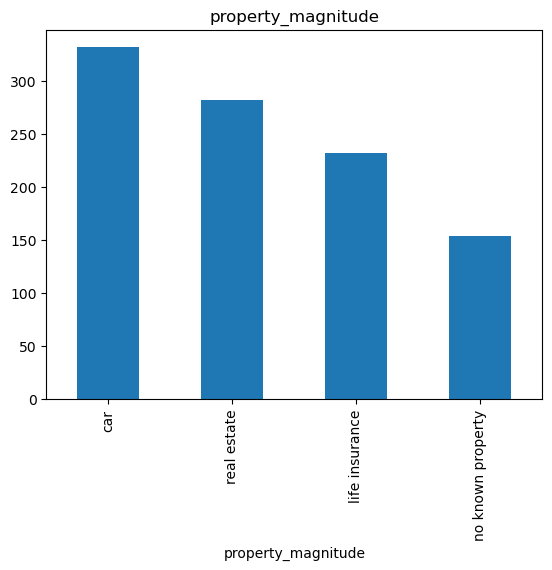

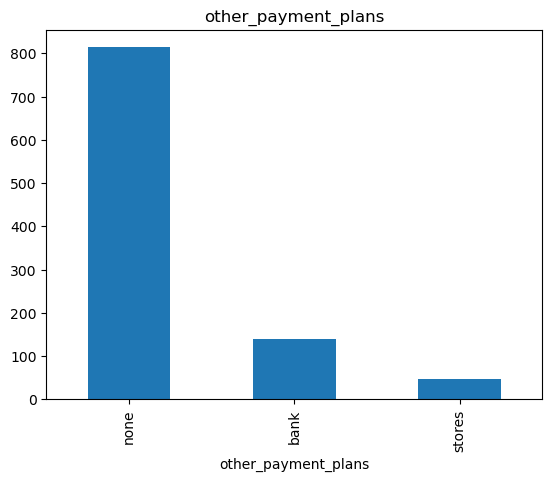

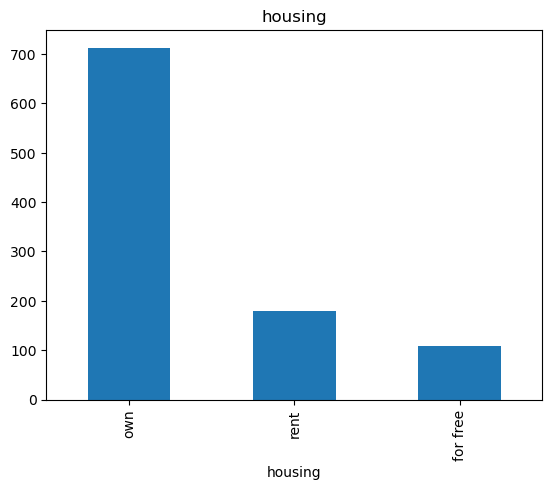

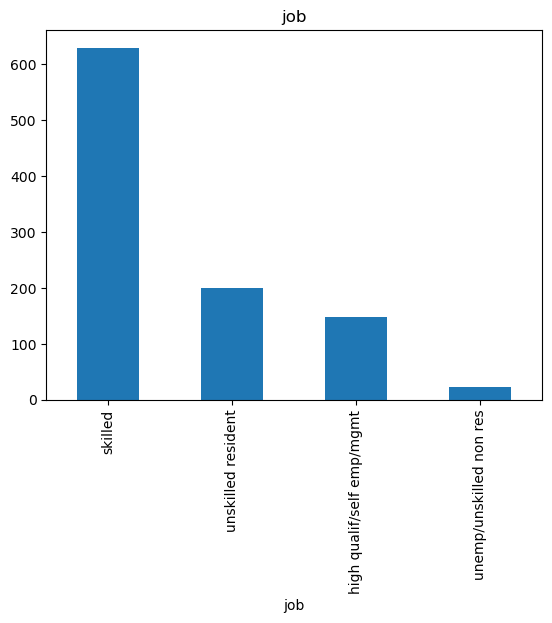

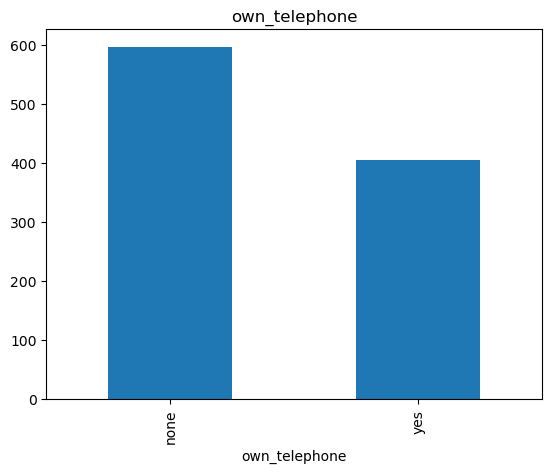

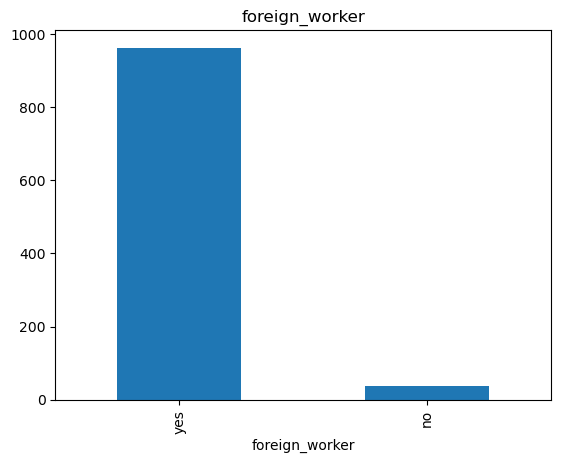

In [20]:
for column in categorical_columns:
    X[column].value_counts().plot(kind='bar', title=column)
    plt.show();

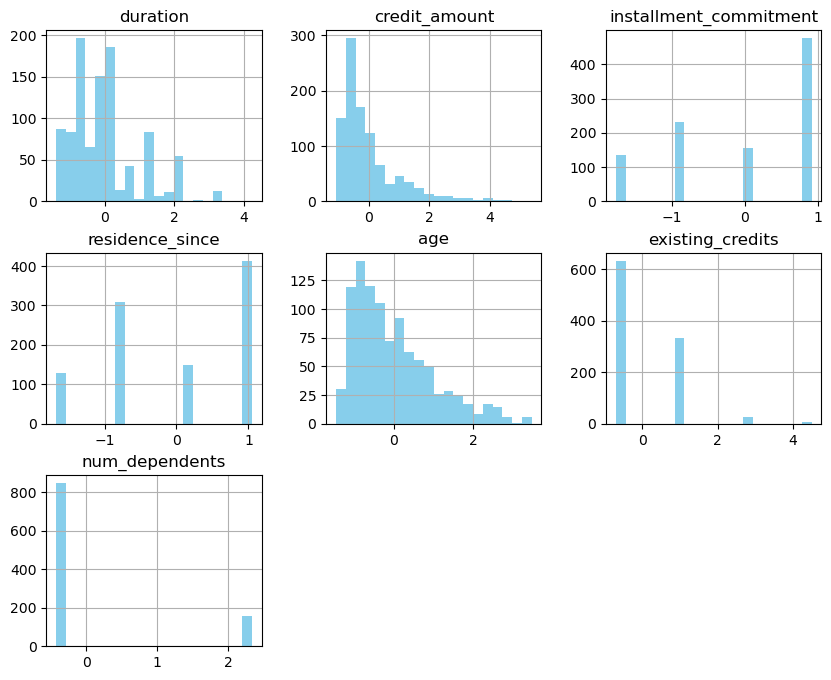

In [21]:
X[numerical_columns].hist(figsize=(10, 8), bins=20, color='skyblue')
plt.show()

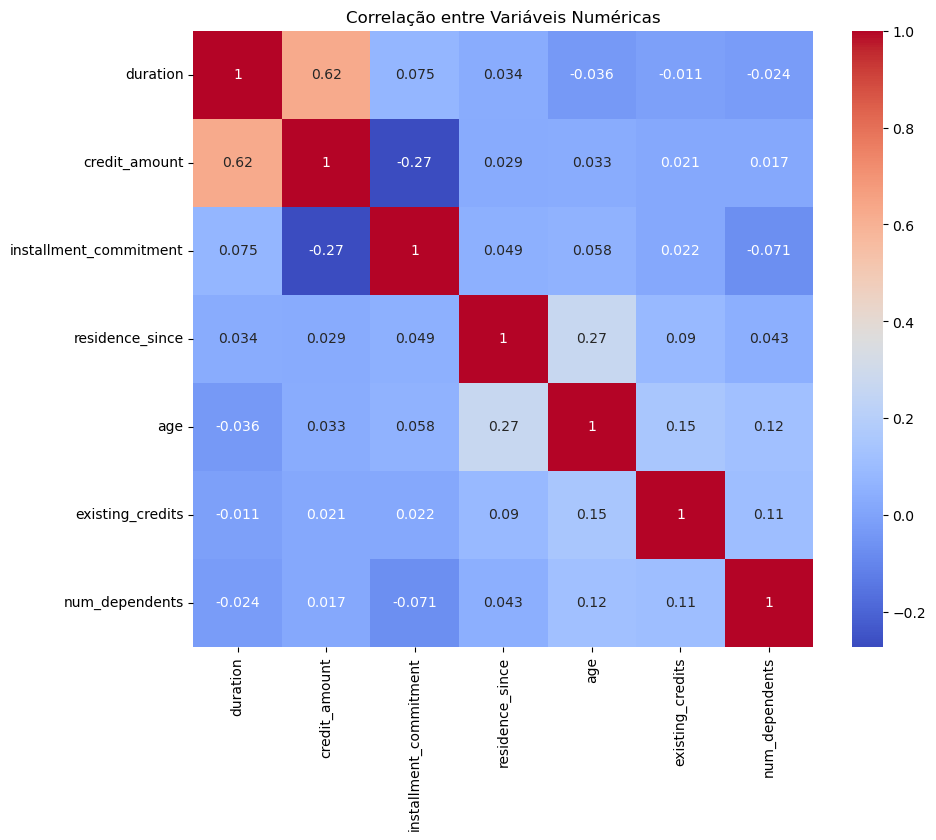

In [24]:
import seaborn as sns

corr = X[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis Numéricas')
plt.show()

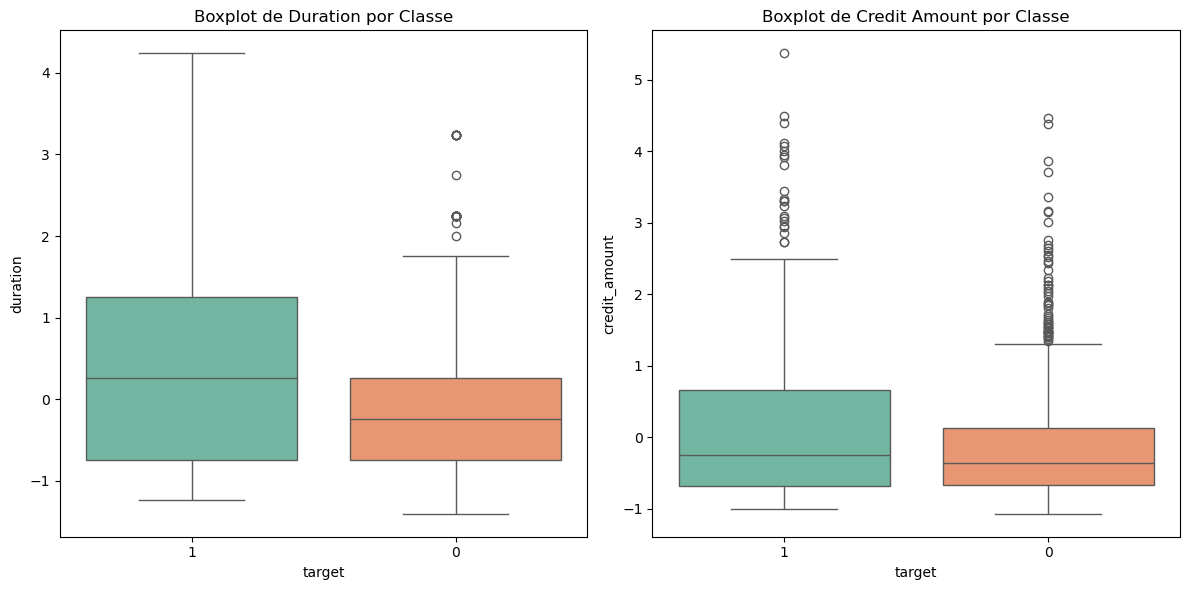

In [25]:
# Criar um DataFrame temporário com X_final e a variável alvo 'y'
df_plot = X_final.copy()
df_plot['target'] = y  # Adicionando a variável alvo ao DataFrame

# Criar uma figura para os gráficos
plt.figure(figsize=(12, 6))

# Boxplot para a variável 'duration' dividido por classe 'target'
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='duration', data=df_plot, hue='target', palette="Set2", legend=False)
plt.title('Boxplot de Duration por Classe')

# Boxplot para a variável 'credit_amount' dividido por classe 'target'
plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='credit_amount', data=df_plot, hue='target', palette="Set2", legend=False)
plt.title('Boxplot de Credit Amount por Classe')

# Exibir os gráficos
plt.tight_layout()
plt.show()

## Separando os dados tratados em conjuntos de treino e teste

In [26]:
# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=SEED)

## Aplicando SMOTE para balanceamento das classes

In [27]:
# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificar a nova distribuição das classes após o SMOTE
print("Distribuição das classes antes do SMOTE:", y_train.value_counts())
print("Distribuição das classes após o SMOTE:", y_train_res.value_counts())

Distribuição das classes antes do SMOTE: class
0    491
1    209
Name: count, dtype: int64
Distribuição das classes após o SMOTE: class
1    491
0    491
Name: count, dtype: int64


## Verificando o resultado mais uma vez

In [28]:
X_train_res.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0,checking_status_200,checking_status_nochecking,...,property_magnitude_realestate,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_skilled,job_unempunskillednonres,job_unskilledresident,own_telephone_yes,foreign_worker_yes
0,0.256953,-0.439247,0.918477,1.046987,2.150789,1.027079,-0.428290,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,-0.738668,-0.491704,0.918477,1.046987,0.303788,-0.704926,-0.428290,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.754763,0.124318,0.918477,1.046987,1.886932,1.027079,-0.428290,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,-0.738668,-0.819919,-0.870183,0.140505,1.007407,1.027079,2.334869,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.252574,0.864750,0.918477,-0.765977,0.215835,1.027079,-0.428290,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


## Definindo as funções para aplicar o algoritmo com Otimização Bayseana e Avaliação do melhor Modelo

In [37]:
# Função para otimizar modelos e calcular o melhor threshold
def find_best_threshold(y_true: np.ndarray, y_scores: np.ndarray, metric: str = 'f1') -> Tuple[float, float]:
    """
    Função para encontrar o melhor threshold para a métrica escolhida (f1, precisão, recall).
    """
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)

    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

def optimize_ensemble_models(X_train_res, X_test_scaled, y_train_res, y_test, metric='f1'):
    param_spaces = {
        'random_forest': {
            'n_estimators': (10, 200),
            'max_depth': (None, 5, 10, 20, 30),
            'min_samples_split': (2, 5, 10, 20)
        },
        'adaboost': {
            'n_estimators': (10, 400),
            'learning_rate': (0.01, 1.0)
        },
        'xgboost': {
            'n_estimators': (100, 500),
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.2, 1.0)
        }
    }

    best_auc = 0
    best_model = None

    models = {
        'random_forest': RandomForestClassifier(random_state=SEED),
        'adaboost': AdaBoostClassifier(algorithm='SAMME', random_state=SEED),
        'xgboost': XGBClassifier(eval_metric='logloss', random_state=SEED)
    }

    for model_name, model in models.items():
        bayes_search = BayesSearchCV(model, param_spaces[model_name], 
                                     n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, random_state=SEED)
        bayes_search.fit(X_train_res, y_train_res)
        best_params = bayes_search.best_params_

        model.set_params(**best_params)
        model.fit(X_train_res, y_train_res)

        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"{model_name} AUC: {auc_score:.4f}")

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model

    print(f"\nMelhor modelo: {type(best_model).__name__} com AUC: {best_auc:.4f}")

    best_threshold, best_metric_score = find_best_threshold(y_test, y_pred_proba, metric=metric)
    y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)

    print(f"\nThreshold ótimo ({metric}): {best_threshold:.2f}")
    print("\nMatriz de Confusão Ajustada:")
    print(cm)
    print(f"\nPrecisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc="lower right")
    plt.show()

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title(f'Curva Precision-Recall')
    plt.show()

    return best_model, X_test_scaled, y_test

def explain_model(best_model: Any, X_test: np.ndarray, feature_names: list):
    """
    Gera gráficos SHAP para interpretar o modelo treinado.
    """
    X_test_dense = pd.DataFrame(X_test.toarray() if isinstance(X_test, csr_matrix) else X_test, columns=feature_names)
    X_test_dense = X_test_dense.apply(pd.to_numeric, errors='coerce')

    if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1] if isinstance(best_model, RandomForestClassifier) else shap_values
    elif isinstance(best_model, AdaBoostClassifier):
        explainer = shap.KernelExplainer(best_model.predict_proba, X_test_dense)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1]
    else:
        raise ValueError(f"Modelo {type(best_model)} não suportado.")

    shap.summary_plot(shap_values_class_1, X_test_dense)
    
    plt.show()

    # Calcular a média dos valores SHAP ao longo de todas as amostras para obter a importância das features
    shap_values_mean = np.mean(shap_values_class_1, axis=0)
    
    # Gerar o gráfico de barras horizontais
    shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=20)
     
    plt.show()

    # Retornar os valores SHAP para uso posterior
    return shap_values_class_1, X_test_dense  # Aqui é onde garantimos o retorno

## Guardando os nomes das colunas para uso da função `explain_model` (SHAP)

In [33]:
feature_names = X_final.columns

## Aplicando o algoritmo nos dados tratados

random_forest AUC: 0.8022
adaboost AUC: 0.7970
xgboost AUC: 0.7962

Melhor modelo: RandomForestClassifier com AUC: 0.8022

Threshold ótimo (f1): 0.05

Matriz de Confusão Ajustada:
[[118  91]
 [ 12  79]]

Precisão: 0.4647
Recall: 0.8681
F1-Score: 0.6054


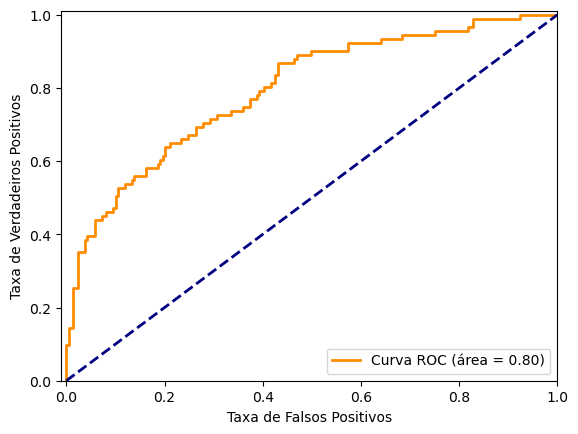

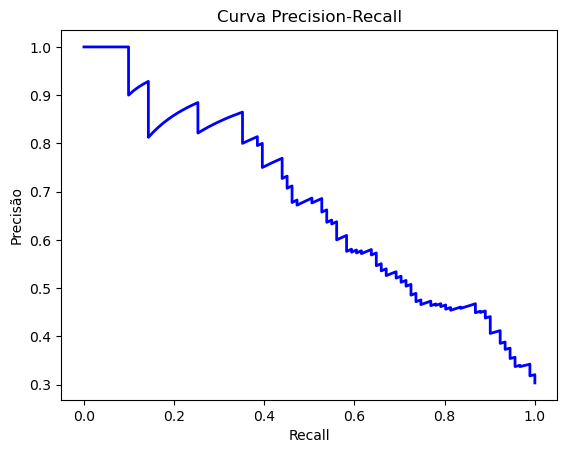

CPU times: user 2min 29s, sys: 2.84 s, total: 2min 32s
Wall time: 1min 17s


In [31]:
%%time
# Otimizar modelos e encontrar o melhor
best_model, X_test, y_test = optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test)

## Verificando os gráficos SHAP para interpretabilidade do modelo escolhido

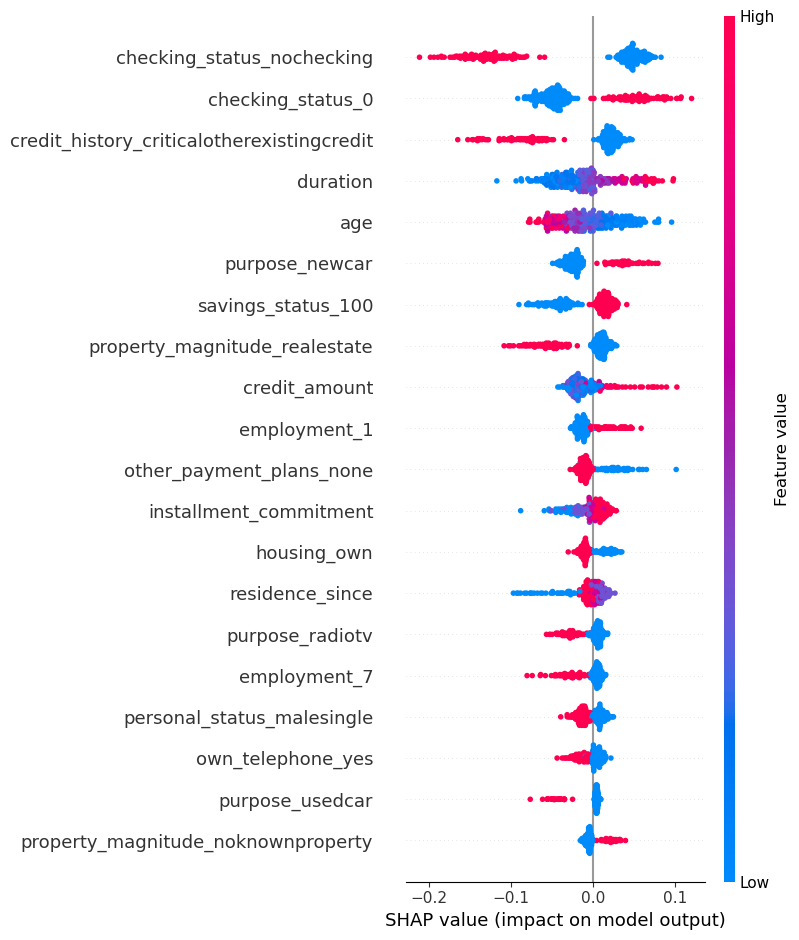

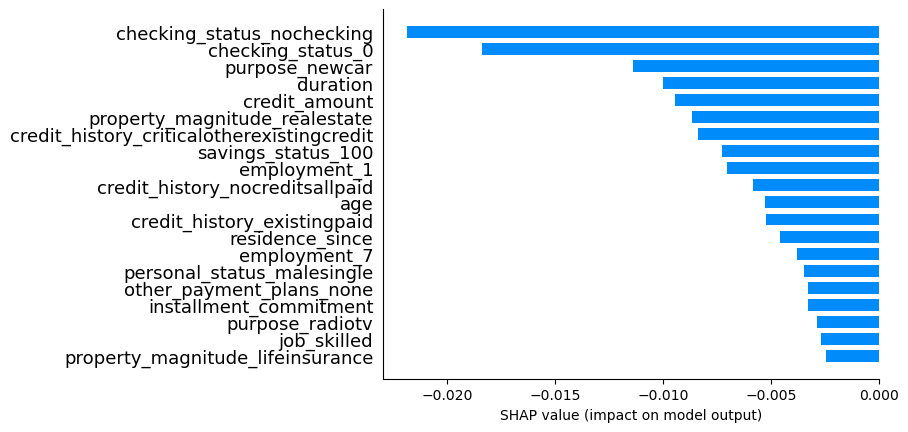

In [38]:
# Interpretabilidade com SHAP
# Chamar a função sem imprimir os retornos
shap_values_class_1, X_test_dense = explain_model(best_model, X_test, feature_names)

## Aplicando transformação logaritmica nas variáveis assimétricas `duration` e `credit_amount`

In [39]:
# Carregar o dataset German Credit de OpenML
data = fetch_openml(name='credit-g', version=1, as_frame=True)

# Transformar as features e o target em DataFrame do Pandas
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [40]:
# Passo 1: Imputar valores ausentes
# Para variáveis categóricas, usar a moda
cat_imputer = SimpleImputer(strategy='most_frequent')
# Para variáveis numéricas, usar a mediana
num_imputer = SimpleImputer(strategy='median')

In [41]:
# Aplicar a imputação nas colunas categóricas e numéricas
X[categorical_columns] = cat_imputer.fit_transform(X[categorical_columns])
X[numerical_columns] = num_imputer.fit_transform(X[numerical_columns])

In [42]:
# Passo 2: Aplicar transformação log nas variáveis numéricas selecionadas
X_transformed = X.copy()
X_transformed['credit_amount'] = X_transformed['credit_amount'].apply(lambda x: np.log(x) if x > 0 else np.log(0.001))
X_transformed['duration'] = X_transformed['duration'].apply(lambda x: np.log(x) if x > 0 else np.log(0.001))

In [43]:
# Passo 3: Aplicar o StandardScaler nas variáveis numéricas (log e não-log)
scaler = StandardScaler()

# Listar as variáveis numéricas não-log e log-transformadas
numeric_cols_to_scale = ['age', 'installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']
numeric_cols_log_transformed = ['credit_amount', 'duration']

In [44]:
# Escalonar as variáveis
X_transformed[numeric_cols_to_scale] = scaler.fit_transform(X_transformed[numeric_cols_to_scale])
X_transformed[numeric_cols_log_transformed] = scaler.fit_transform(X_transformed[numeric_cols_log_transformed])

In [45]:
# Passo 4: Codificar as variáveis categóricas (One-Hot Encoding)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(X_transformed[categorical_columns]), 
                            columns=encoder.get_feature_names_out(categorical_columns))

In [46]:
# Obter os nomes das colunas geradas pelo One-Hot Encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)

In [47]:
# Transformar o array em um DataFrame com os nomes das colunas
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

In [48]:
# Garantir que as colunas codificadas são do tipo float
encoded_cats = pd.DataFrame(encoded_cats, columns=encoded_feature_names).astype(float)

In [49]:
# Passo 5: Concatenar as variáveis numéricas transformadas e categóricas codificadas
X_final = pd.concat([X_transformed[numeric_cols_to_scale + numeric_cols_log_transformed], encoded_cats], axis=1)

In [50]:
# Limpar os nomes das colunas para remover caracteres problemáticos
X_final.columns = X_final.columns.str.replace(r'[><=]', '', regex=True)
X_final.columns = X_final.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)

In [51]:
X_final.columns = X_final.columns.astype(str)

In [52]:
# Converter a variável alvo 'y' para binário (0 para 'good', 1 para 'bad')
y = y.apply(lambda x: 1 if x == 'bad' else 0)

In [53]:
# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=SEED)

# Aplicar SMOTE no conjunto de treino
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificar a nova distribuição das classes após o SMOTE
print("Distribuição das classes antes do SMOTE:", y_train.value_counts())
print("Distribuição das classes após o SMOTE:", y_train_res.value_counts())

Distribuição das classes antes do SMOTE: class
0    491
1    209
Name: count, dtype: int64
Distribuição das classes após o SMOTE: class
1    491
0    491
Name: count, dtype: int64


random_forest AUC: 0.7986
adaboost AUC: 0.7946
xgboost AUC: 0.7959

Melhor modelo: RandomForestClassifier com AUC: 0.7986

Threshold ótimo (f1): 0.35

Matriz de Confusão Ajustada:
[[167  42]
 [ 30  61]]

Precisão: 0.5922
Recall: 0.6703
F1-Score: 0.6289


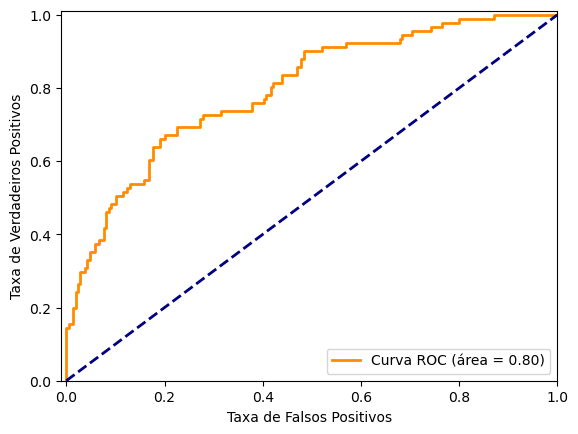

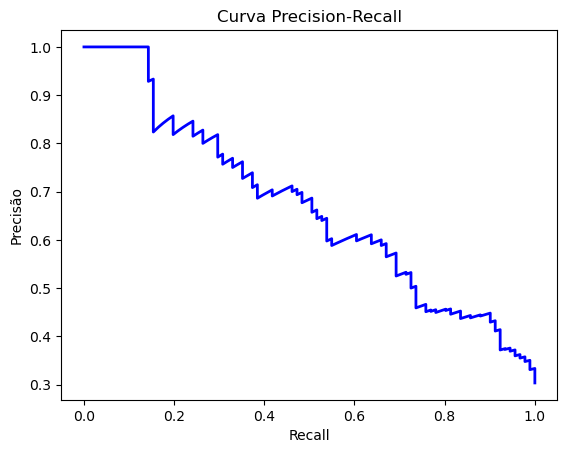

CPU times: user 2min 46s, sys: 3.49 s, total: 2min 49s
Wall time: 1min 24s


In [55]:
%%time
# Otimizar modelos e encontrar o melhor
best_model, X_test, y_test = optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test)

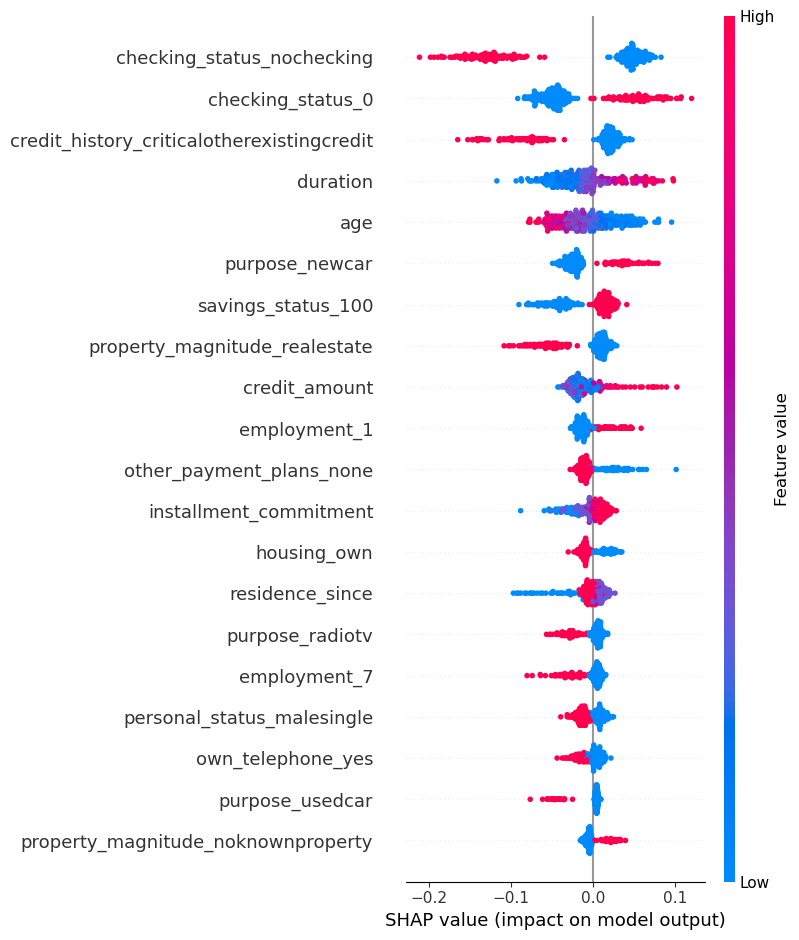

In [56]:
# Gerar o gráfico de dispersão SHAP sem exibir
shap.summary_plot(shap_values_class_1, X_test_dense, show=False)

# Mostrar o gráfico na tela (opcional)
plt.show()

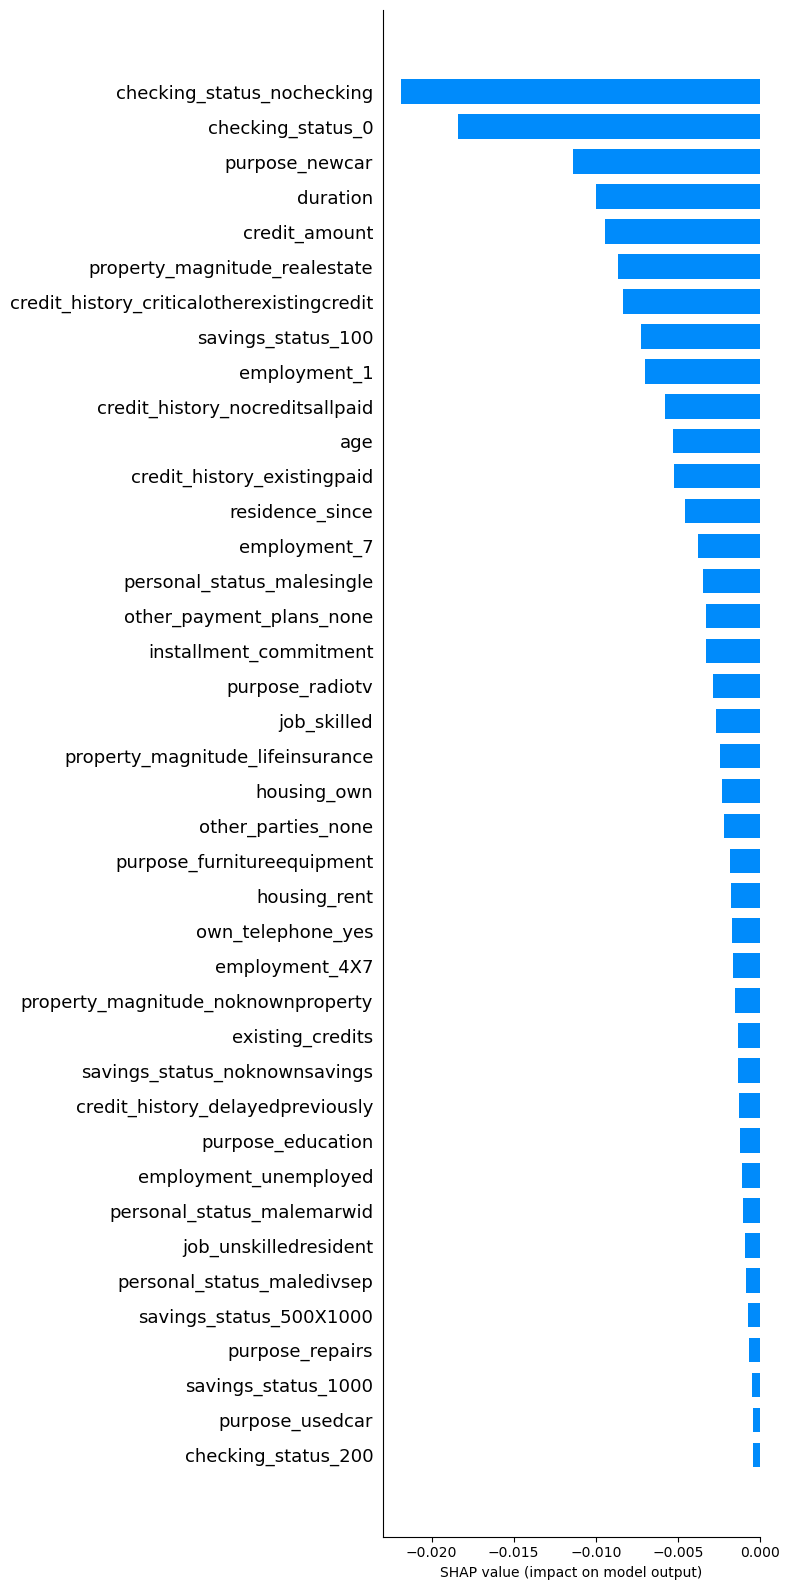

In [59]:
# Gerar o gráfico de barras SHAP sem exibir

# Definir o tamanho da figura (width, height)
plt.figure(figsize=(8, 16))  # Ajuste os valores conforme necessário

# Calcular a média dos valores SHAP ao longo de todas as amostras para obter a importância das features
shap_values_mean = np.mean(shap_values_class_1, axis=0)

shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=40, show=False)

# Ajustar o layout para evitar que o gráfico fique cortado
plt.tight_layout()

# Mostrar o gráfico na tela (opcional)
plt.show()